# MIMIC-III WFDB dataset

PhysioNet 에서 제공하는 데이터를 확보하고 데이터를 확인하는 단계이다.

**Output:** `/root/Workspace/DataWarehouse/mimic-iii_wfdb/all_patient_records.pickle.gzip`
- 모든 환자의 record_name 들을 갖고 있는 List 파일이다.

In [1]:
import os
import pickle
import gzip
import re
import multiprocessing
import wfdb
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

CDB_PATH = '/root/Workspace/DataLake/mimic-iii_cdb/files/mimiciii/1.4/'
WFDB_PATH = '/root/Workspace/DataLake/mimic-iii_wfdb/'

In [2]:
def get_depth(path):
    return len(path.split('/'))


def list_subdir(path):
    return [file.path for file in os.scandir(path) if file.is_dir()]


def list_record(path, re_expression):
    regex = re.compile(re_expression)
    return [file.path for file in os.scandir(path) if regex.match(file.path.split(path+'/').pop()) != None]

In [3]:
sub_dir = list_subdir(WFDB_PATH) 

In [4]:
def test(dirpath):
    patient_records = []
    # for entry in os.walk(sub_dir[0]):
    for entry in os.walk(dirpath):
        path, _, _ = entry
        if get_depth(path) > 6:
            patient_records.append(list_record(path, 'p[0-9]{6}-[0-9]{4}[0-9\-]+n?.hea'))

    return patient_records

# sub_dir 0부터 9 까지를 전부 비동기적으로 돌리면 어떨까?

In [5]:
pool = multiprocessing.Pool(processes=10)
records = pool.map(test, sub_dir)
pool.close()
pool.join()
# records2 = [test(sub_dir[i]) for i in range(len(sub_dir))]
# len(records2[0])

#### Verification
- default time spent: 6m 47.8s
- multiprocessing time spent: 4m 32s
- total count: 10282, icu records
    - dir_0: 1244
    - dir_1: 1171
    - dir_2: 1179
    - dir_3: 255
    - dir_4: 1070
    - dir_5: 1084
    - dir_6: 1087
    - dir_7: 1029
    - dir_8: 1081
    - dir_9: 1082

Record 는 전체 데이터를 의미한다.

Header 는 Record 의 헤더 데이터만을 의미한다.

Multi-segment 는 한 환자 내의 Record 가 여러 파일로 쪼개진 것들을 의미한다.

Sample 은 Record 와 동일하게 signal 과 field 를 가져오지만 좀 더 단순화/간편화 되었다.

전체 디렉터리는 10,282 개이다.

> https://github.com/MIT-LCP/wfdb-python/blob/main/demo.ipynb 참고

In [6]:
records[0][7][0][:-4]

'/root/Workspace/DataLake/mimic-iii_wfdb/p00/p000109/p000109-2141-10-21-02-00'

In [7]:
signals, fields = wfdb.rdsamp(records[0][7][0][:-4])
wfdb.plot_items(signal=signals, fs=fields['fs'], title='Record p000109-2141-10-21-02-00')
display(signals, fields)

display(wfdb.rdheader('/root/Workspace/DataLake/mimic-iii_wfdb/p00/p000109/p000109-2141-10-21-02-00').__dict__)
display(wfdb.rdheader('/root/Workspace/DataLake/mimic-iii_wfdb/p00/p000109/3034224_layout').__dict__)
# record = wfdb.rdrecord(patient_records[7][0])
# display(record.__dict__)

# pn_dir 를 이용해서 physionet 에 접근하여서 가져올 수도 있다.
# test_record2 = wfdb.rdrecord('p000020-2183-04-28-17-47', pn_dir='mimic3wdb/matched/p00/p000020')
# test_record2.__dict__

KeyboardInterrupt: 

In [ ]:
signals.shape

(8561, 12)

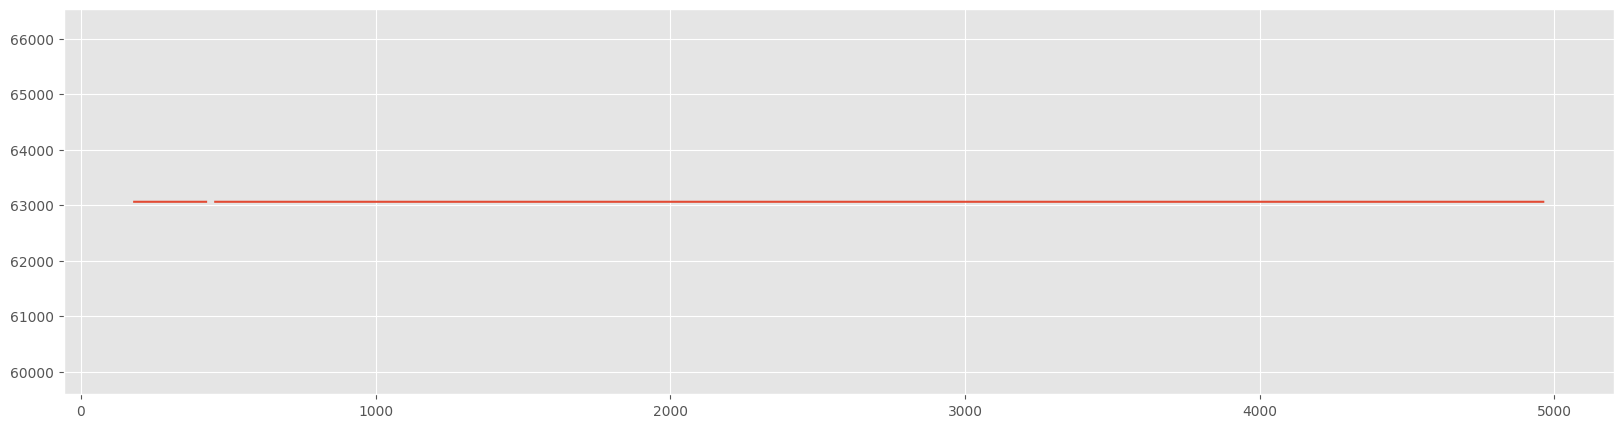

In [ ]:
fig, axs = plt.subplots(1,1, figsize=(20,5))
axs.plot(signals[:,-1])
# axs.set_xlim(100000,103000)
plt.show()

In [ ]:
len(records)

10

#### Save result by Pickle (feat. gzip)

In [18]:
# save and compress
with gzip.open('/root/Workspace/DataWarehouse/mimic-iii_wfdb/00_all_patient_records.pickle.gzip', 'wb') as f:
    pickle.dump(records, f)